# Visual odometry using monocular vision

The purpose of this project is to determine the displacement of the camera based on the series of frames it captures.

In [1]:
import cv2
import numpy as np
import os
import math
from matplotlib import pyplot as plt

In [2]:
%matplotlib inline
# Set figure width to 12 and height to 9
plt.rcParams["figure.figsize"] = (12, 9)

In [3]:
directory = "test_z_plus_rotation"
frame_names = [name for name in os.listdir("{}".format(directory)) if name.endswith(".bmp")]

## Features detection and matching

The first stage of this algorythm is to find key points and corresponding descriptors for each frame. This was achieved using the ORB (Oriented FAST and Rotated BRIEF) algorythm. Haveing key points and descriptors we are able to match corresponding points between frames. FLANN Based Matcher (Fast Library for Approximate Nearest Neighbors) was used for this purpose. The knn match was used with k = 2 in order to be able to apply the Lowe's ratio test. Having matched descriptors we can find the coordinates of the corresponding points, what will be used for displacement calculation.

In [4]:
orb = cv2.ORB_create()
FLANN_INDEX_LSH = 6
index_params= dict(algorithm = FLANN_INDEX_LSH,
                   table_number = 6, # 12
                   key_size = 12,     # 20
                   multi_probe_level = 1) #2
search_params = dict(checks=50)
flann_matcher = cv2.FlannBasedMatcher(index_params, search_params)
ref_point = np.zeros((3,1), dtype=np.float)
K = np.zeros((3,3), dtype=float)
K[0,0] = 843
K[1,1] = 843
K[2,2] = 1
K[0,2] = 512
K[1,2] = 384
print(K)
angle_x, angle_y, angle_z = 0, 0, 0

[[843.   0. 512.]
 [  0. 843. 384.]
 [  0.   0.   1.]]


In [5]:
frame = cv2.imread('{}/{}'.format(directory, frame_names[0]), 1)
kp1, des1 = orb.detectAndCompute(frame, None)

## Lowe's ratio

As mentioned above, the Lowe's ratio test is applied in order to find only good matches. The match is considered a good match, if the difference in distance for the 2 of the matched descriptors, for the tested descriptor, is big enough (in this case distance1 < 0.7 * distance2), where distance means the distance between descriptors. The lower, the better it is.

In [6]:
def filter_matches(matches):
    good_matches = []
    for match in matches:
        if len(match) == 2:
            if match[0].distance < 0.7 * match[1].distance:
                good_matches.append(match[0])
        elif len(match) == 1:
            good_matches.append(match[0])
    return good_matches

## Matches coordinates

Having matches we can create two sets of corresponding points coordinates. The coresponding points are under the same indices.

In [7]:
def extract_coordinates(matches):
    first_set = []
    second_set = []
    for match in good_matches:
        first_set += [kp1[match.queryIdx].pt]
        second_set += [kp2[match.trainIdx].pt]

    first_set = np.array(first_set, dtype=np.float32)
    second_set = np.array(second_set, dtype=np.float32)
    return first_set, second_set

In [8]:
def draw_matches(first_set, second_set, frame):
    for p1, p2 in zip(first_set, second_set):
        cv2.arrowedLine(frame, (int(p1[0]), int(p1[1])), (int(p2[0]), int(p2[1])), (255, 0, 0), 2)
    plt.imshow(frame)
    plt.show()

## Euler angles

Having a 3x3 rotation matrix, obtained from the *recoverPose()* function, we can calculate 3 elementary Euler angles, sometimes referred to as yaw/pitch/roll. There are a few ways to accomplish it and all of them are valid. But the approach used here is based on the one presented in: http://nghiaho.com/?page_id=846.

In [9]:
def calculate_euler_angles(rotation_matrix):
    x_angle = math.atan2(R[2,1] , R[2,2])
    y_angle = math.atan2(-R[2,0], math.sqrt(R[2,1] ** 2 +  R[2,2] ** 2))
    z_angle = math.atan2(R[1,0], R[0,0])
    return x_angle, y_angle, z_angle

## Displacement

Having two sets of corresponding points coordinates, we can find the rotation and translation of the camera. The first step is to find essential matrix, this is done by the function *findEssentialMatrix()*. It is a 3x3 matrix containing the information about the translation and rotation. It is calculated using *D. Nisters'* algorythm, that is described in the article *"An efficient solution to the five-point relative pose problem"*. In the above algorythm the calssification to inliers and outliers is done by the *RANSAC (Random sampe consensus)* algorythm. The idea is to choose from the set of points a random subset and to fit a linear model to this subset. This proces is repeated several times. Finally the model with the smallest error is chosen, based on the assumption that the linear correlation is bigger for the inliers than for the random points. The effectiveness of this algorythm, depends on the ratio of inliers to outliers, due to the fact that the points are selected randomly from the whole set of points. We cannot be sure that the chosen set contains only inliers, so the bigger the ratio between inliers and outliers, the better the result of this algorythm.
The next step is to pass previously calculated essential matrix to the function *recoverPose()*. This function uses the *SVD (Singular Value Decomposition)* decomposition to find all 4 possible pairs of the translation and rotation matrix, that are [$R_{1}$, t], [$R_{1}$, -t], [$R_{2}$, t], [$R_{2}$, -t]. Having all 4 pairs, points correspondances and using the *cheirality check* (that basically means that the triangulated 3D points should have positive depth), the function chooses the right pair from 4 avalable. After this step we are able to determine the translation and rotation of the camera.

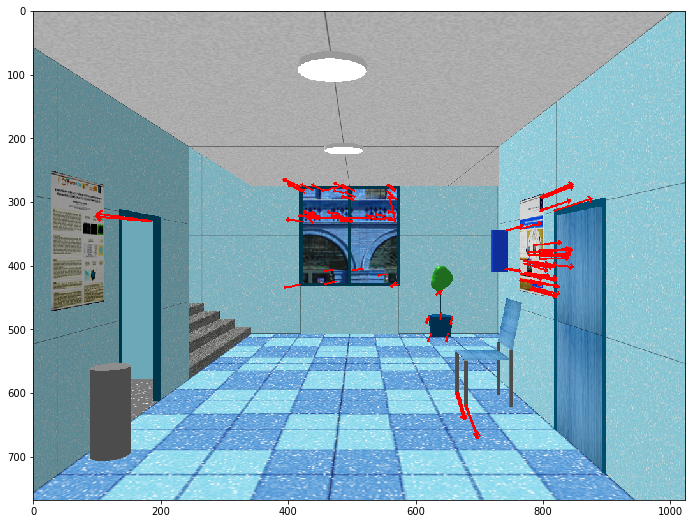

0.0005828333218904557 -0.03430934341694082 -0.006694774796008183


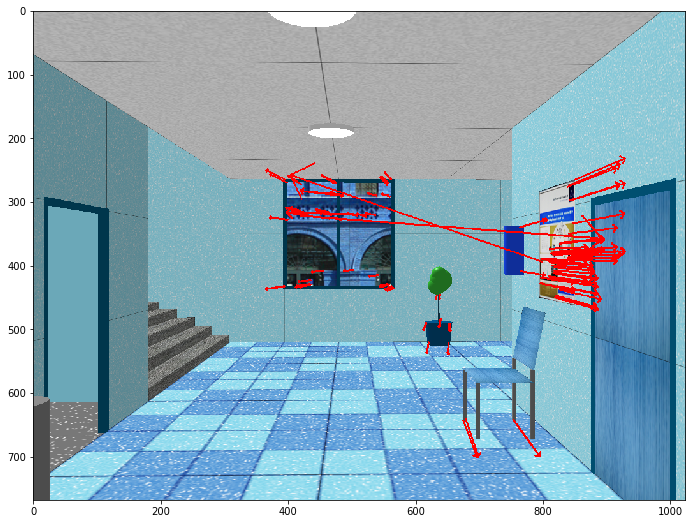

0.0054298606153383635 -0.03310084528024461 -0.008889411989504077


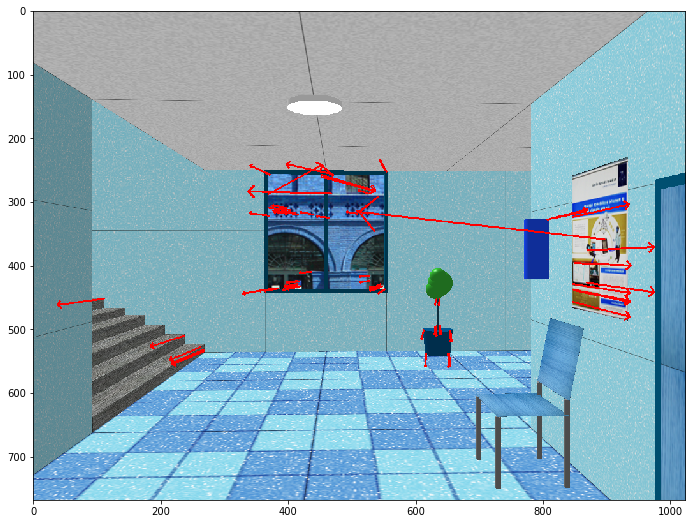

-0.004790502417018371 -0.03675856438403106 0.00324357496714903


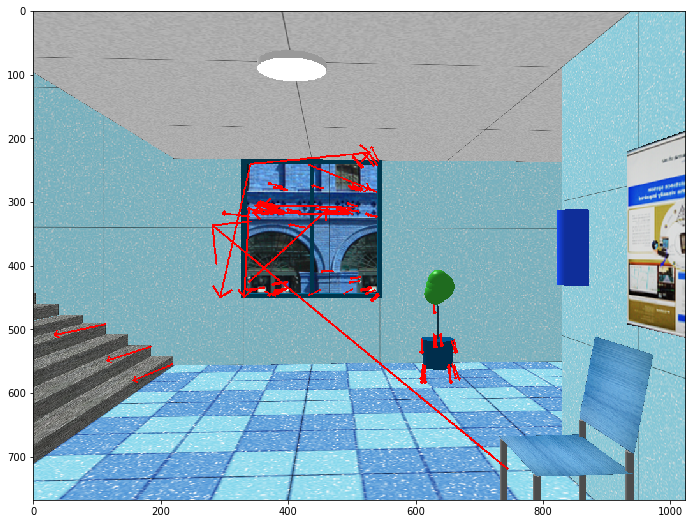

-0.0026523833589177366 -0.037486173430560286 0.0015163123263235163


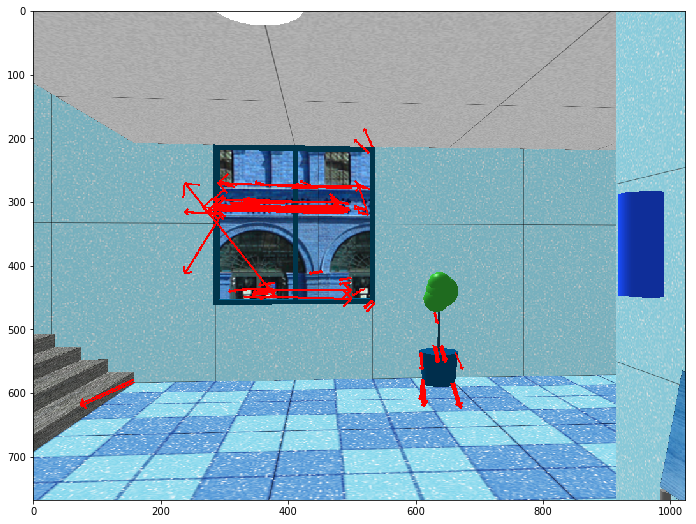

0.001461410771053584 -0.035889256462928044 -0.004622305417767287


In [10]:
for frame_name in frame_names[1:]:
    
    frame_copy = frame.copy()
    frame_copy2 = frame.copy()
    
    next_frame = cv2.imread('{}/{}'.format(directory, frame_name), 1)
    kp2, des2 = orb.detectAndCompute(next_frame, None)

    matches = flann_matcher.knnMatch(des1, des2, k=2)
    
    good_matches = filter_matches(matches)
    
    first_set, second_set = extract_coordinates(good_matches)
            
    draw_matches(first_set, second_set, frame)
    
    if first_set.shape[0] >= 5:

        essential_matrix, mask = cv2.findEssentialMat(first_set, second_set, 389.0, (512.0, 384.0), cv2.RANSAC, 0.999, 1.0)
        #hom, mask2 = cv2.findHomography(first_set, second_set, method=cv2.RANSAC, ransacReprojThreshold=3)
        #_, r, t, n = cv2.decomposeHomographyMat(hom, K)
        #first_set_1 = np.array([[point] for point in first_set], dtype=np.float32)
        #second_set_1 = np.array([[point] for point in second_set], dtype=np.float32)
        #possible_solutions = cv2.filterHomographyDecompByVisibleRefpoints(r, n, first_set_1, second_set_1, pointsMask=mask2)
        #R = r[possible_solutions[0][0]]
        #first_set_copy = np.array([x for i, x in enumerate(first_set) if mask2[i] == 1])
        #second_set_copy = np.array([x for i, x in enumerate(second_set) if mask2[i] == 1])
        
        #draw_matches(first_set_copy, second_set_copy, frame_copy)
        
        points, R, t, mask = cv2.recoverPose(essential_matrix, first_set, second_set, focal=389.0, pp=(512.0, 384.0), mask=mask)
        
        x, y, z = calculate_euler_angles(R)
        angle_x += x
        angle_y += y
        angle_z += z
        print(x, y, z)
        
        #first_set_copy = np.array([x for i, x in enumerate(first_set) if mask[i] == 1])
        #second_set_copy = np.array([x for i, x in enumerate(second_set) if mask[i] == 1])
        #draw_matches(first_set_copy, second_set_copy, frame_copy2)
        
        ref_point = np.matmul(R, ref_point) + t
    else:
        print("Not enough corresponding features found")
    
    kp1 = kp2.copy()
    des1 = des2.copy()
    
    frame = next_frame.copy()

In [11]:
print(ref_point)

[[ 0.3350924 ]
 [ 0.00651095]
 [-4.98140042]]


In [12]:
print(angle_x, angle_y, angle_z)

3.1218932346296045e-05 -0.1775441829747048 -0.015446604909807
